In [83]:
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os

# Mouse brain

In [84]:
basepath = '/stanley/WangLab/kamal/code/remote_notebooks/spin_supps/figures/'
figsize = (5,6)
s = 10
dpi = 300
region_cmap = {str(i):sc.pl.palettes.default_102[i] for i in range(40)}

In [85]:
adata = sc.read_h5ad('/stanley/WangLab/kamal/code/remote_notebooks/spatial_autocorrelation/adata_all_techniques.h5ad')

## Subset data

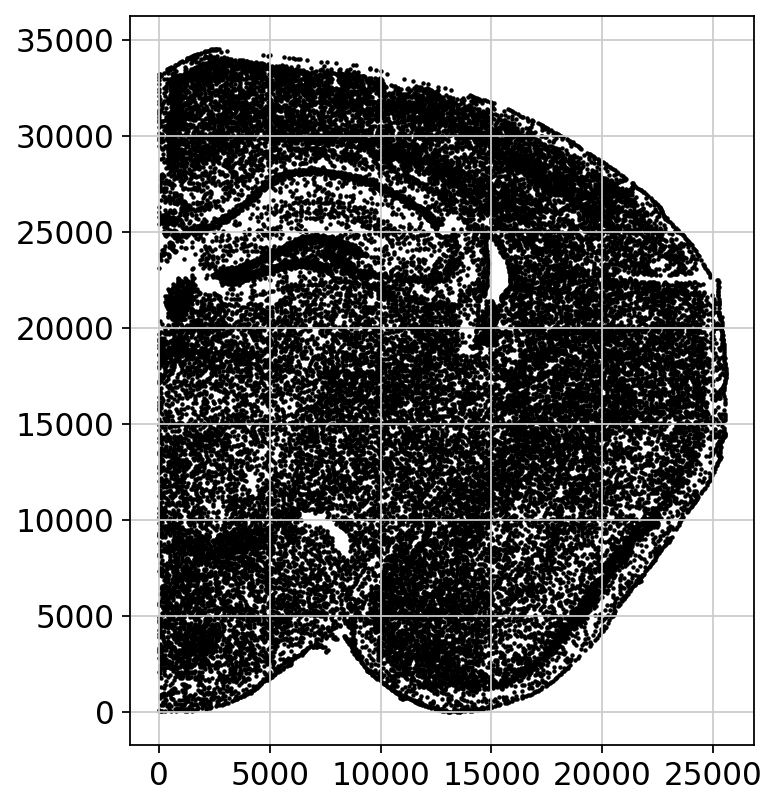

In [86]:
plt.figure(figsize=figsize)
plt.scatter(*adata.obsm['spatial'].T, color='k', s=1)
plt.show()

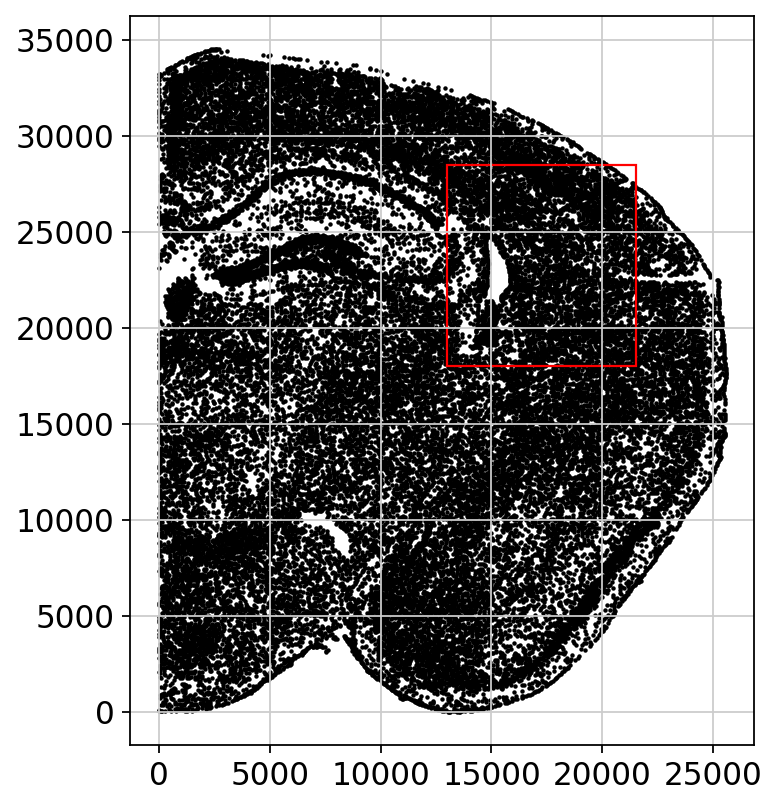

In [100]:
# Choroid plexus
x = 13000
y = 18000
width = 8500
height = 10500

# # RSC
# x = 0
# y = 22000
# width = 10000
# height = 13000

plt.figure(figsize=figsize)
plt.scatter(*adata.obsm['spatial'].T, color='k', s=1)
plt.gca().add_patch(Rectangle((x,y),width,height, facecolor='none', edgecolor='r'))
plt.show()

In [101]:
subdata = adata[adata.obsm['spatial'][:,0] > x]
subdata = subdata[subdata.obsm['spatial'][:,0] < x+width]
subdata = subdata[subdata.obsm['spatial'][:,1] > y]
subdata = subdata[subdata.obsm['spatial'][:,1] < y+width]

## Smooth

In [102]:
def get_nbrs(adata, n_nbrs, spatial_key='spatial'):

    coordinates = adata.obsm[spatial_key]
    nbrs = NearestNeighbors(n_neighbors=n_nbrs)
    nbrs.fit(coordinates)
    _, nbr_idxs = nbrs.kneighbors(coordinates)

    return nbr_idxs


def smooth(adata, nbr_idxs):

    n_nbrs = nbr_idxs.shape[1]
    X_smooth = np.zeros(adata.X.shape)
    for nth_nbrs in np.array(nbr_idxs).T:
        X_smooth += adata.X[nth_nbrs] / n_nbrs

    return X_smooth

In [103]:
n_nbrs_list = [1, 5, 10, 30]
n_pcs = 50

for n_nbrs in n_nbrs_list:

    nbr_idxs = get_nbrs(subdata, n_nbrs)
    subdata.layers[f'smooth_{n_nbrs}'] = smooth(subdata, nbr_idxs)
    subdata.obsm[f'X_pca_{n_nbrs}'] = PCA(n_components=n_pcs).fit_transform(subdata.layers[f'smooth_{n_nbrs}'])

## Kmeans

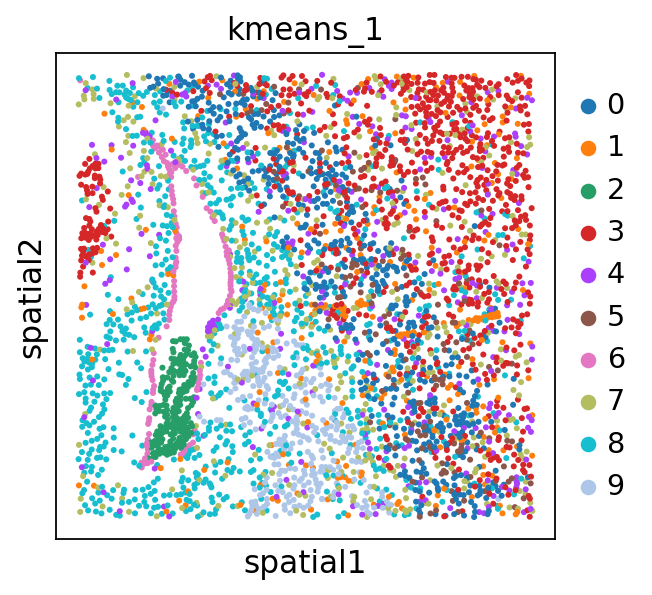

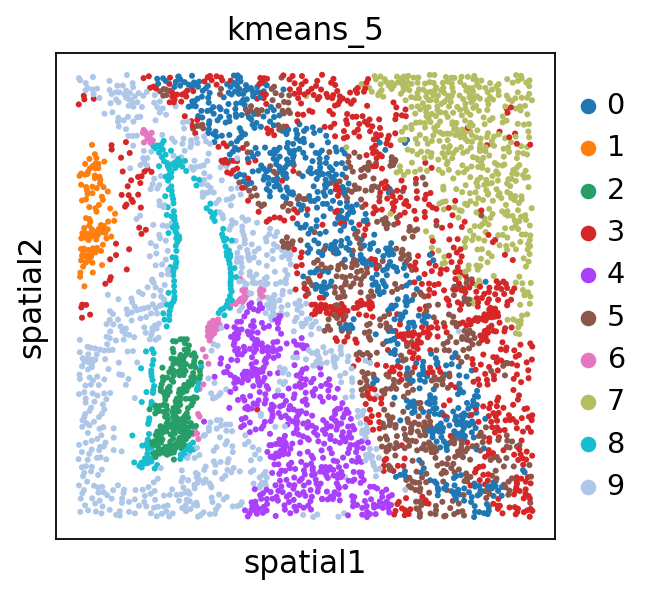

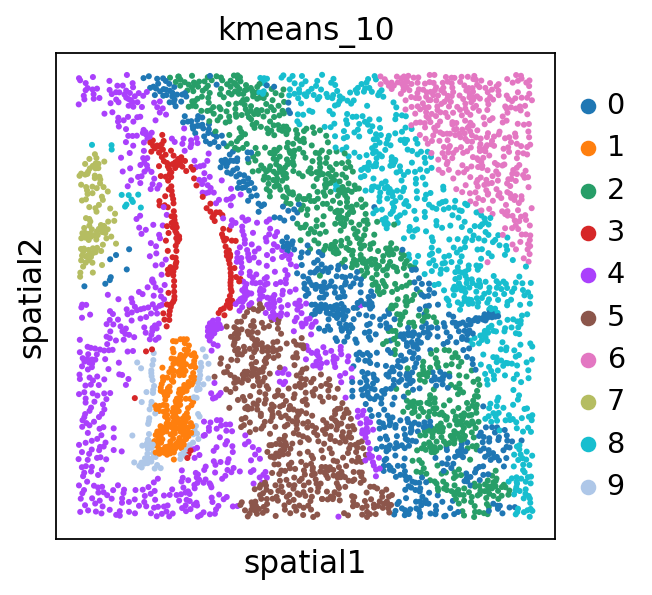

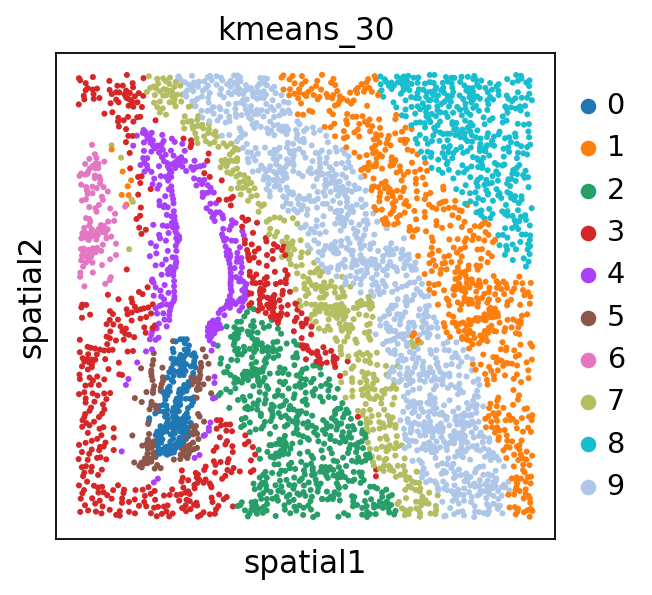

In [156]:
# n_clusters = 10
n_clusters = 10
sc.set_figure_params(figsize=(4,4)) # chpl

for n_nbrs in n_nbrs_list:

    layer = f'smooth_{n_nbrs}'

    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    subdata.obs[f'kmeans_{n_nbrs}'] = kmeans.fit(subdata.obsm[f'X_pca_{n_nbrs}']).labels_.astype(str)

    sc.pl.embedding(subdata, basis='spatial', color=f'kmeans_{n_nbrs}')

## Recolor

In [171]:
layer = 'smooth_subsampled'
regions = adata.obs[f'region_{layer}'].unique()
palette = sc.pl.palettes.default_102
old_cmap = {regions[i]:palette[i] for i in range(len(regions))}

In [176]:
old_cmap

{'L2/3': '#FFFF00',
 'meninges/L1': '#1CE6FF',
 'HPFmo': '#FF34FF',
 'L4': '#FF4A46',
 'L5': '#008941',
 'PIR': '#006FA6',
 'L6': '#A30059',
 'BLA': '#FFDBE5',
 'CP': '#7A4900',
 'fiber tract': '#0000A6',
 'MEA/COA': '#63FFAC',
 'VL': '#B79762',
 'chpl1': '#004D43',
 'HY': '#8FB0FF',
 'CA2/3': '#997D87',
 'RSP': '#5A0007',
 'CA1': '#809693',
 'TH': '#6A3A4C',
 'RT': '#1B4400',
 'DG': '#4FC601',
 'LHb': '#3B5DFF',
 'chpl2': '#4A3B53',
 'MHb': '#FF2F80'}

In [182]:
palette = sc.pl.palettes.default_102
cmap = {
    'L2/3/4': old_cmap['L4'],
    'L5': old_cmap['L5'],
    'L6': old_cmap['L6'],
    'L6b': old_cmap['HPFmo'],
    'fiber_tract': old_cmap['fiber tract'],
    'VL1': old_cmap['VL'],
    'VL2': old_cmap['HY'],
    'chpl': old_cmap['chpl1'],
    'CP': old_cmap['CP'],
    'HPC': old_cmap['CA2/3'],
}

dict1 = {
    '3': 'L2/3/4',
    '5': 'L5',
    '0': 'L6',
    '1': 'L6b',
    '8': 'fiber_tract',
    '6': 'VL1',
    '4': 'VL2',
    '2': 'chpl',
    '9': 'CP',
    '7': 'HPC',
}

dict5 = {
    '7': 'L2/3/4',
    '5': 'L5',
    '0': 'L6',
    '3': 'L6b',
    '9': 'fiber_tract',
    '8': 'VL1',
    '6': 'VL2',
    '2': 'chpl',
    '4': 'CP',
    '1': 'HPC',
}

dict10 = {
    '6': 'L2/3/4',
    '8': 'L5',
    '2': 'L6',
    '0': 'L6b',
    '4': 'fiber_tract',
    '3': 'VL1',
    '9': 'VL2',
    '1': 'chpl',
    '5': 'CP',
    '7': 'HPC',
}

dict30 = {
    '8': 'L2/3/4',
    '1': 'L5',
    '9': 'L6',
    '7': 'L6b',
    '3': 'fiber_tract',
    '4': 'VL1',
    '5': 'VL2',
    '0': 'chpl',
    '2': 'CP',
    '6': 'HPC',
}

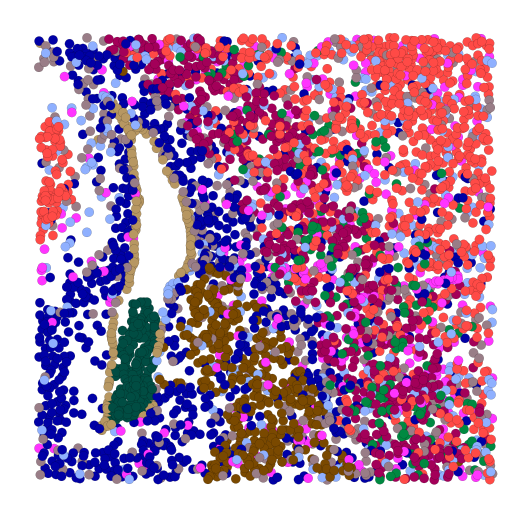

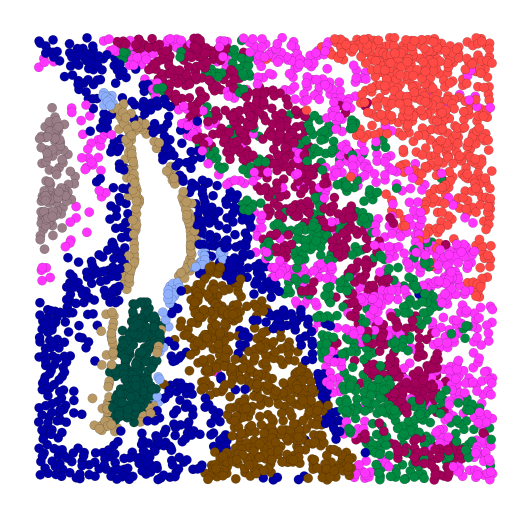

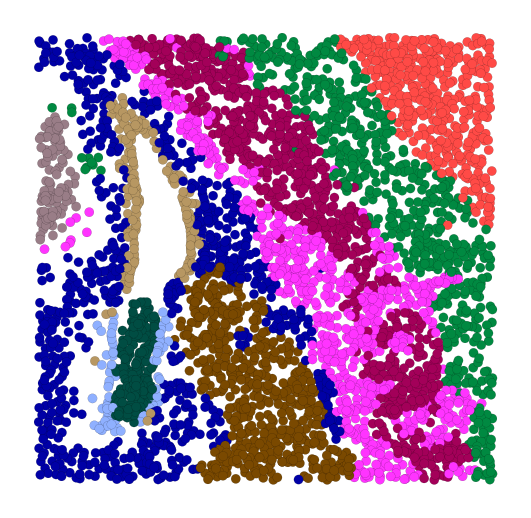

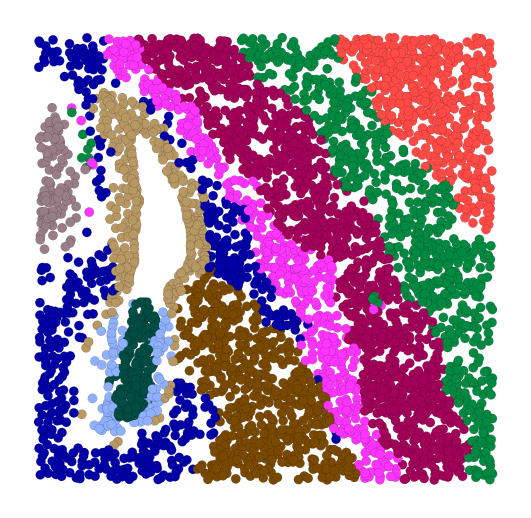

In [187]:
dicts = [dict1, dict5, dict10, dict30]
dictdict = {n_nbrs_list[i]:dicts[i] for i in range(len(n_nbrs_list))}
sc.set_figure_params(figsize=(4,4))

for n_nbrs in n_nbrs_list:

    subdata.obs[f'region_{n_nbrs}'] = subdata.obs[f'kmeans_{n_nbrs}'].map(dictdict[n_nbrs])
    sc.pl.embedding(subdata, basis='spatial', color=f'region_{n_nbrs}', palette=cmap, edgecolor='k', linewidth=0.05, return_fig=True, title='', legend_loc=None, s=70)
    plt.axis('off')
    figname = f'zoom_colored_by_region_{n_nbrs}nbrs.png'
    savepath = os.path.join(basepath, figname)
    plt.savefig(savepath, bbox_inches='tight', transparent=True, dpi=dpi)

/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


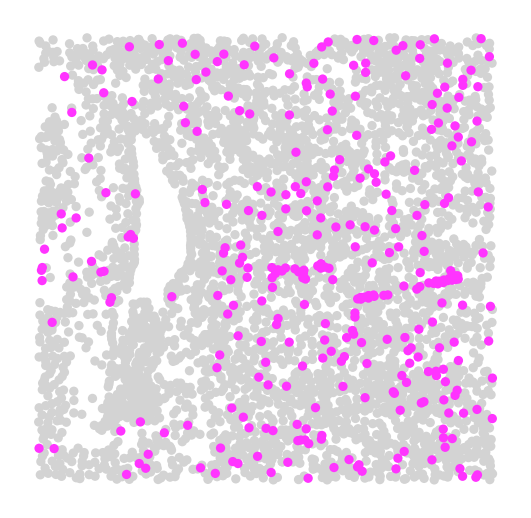

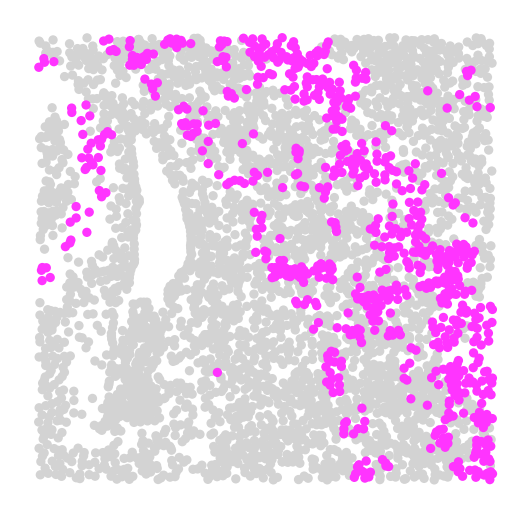

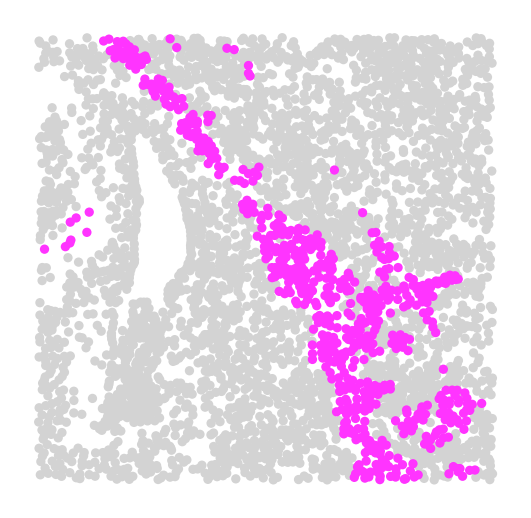

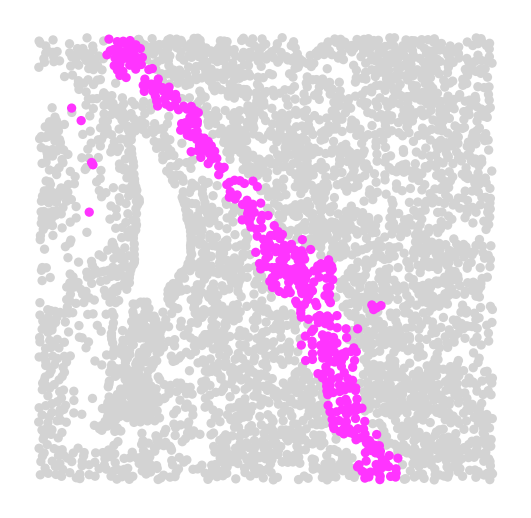

In [186]:
for n_nbrs in n_nbrs_list:

    sc.pl.embedding(subdata, basis='spatial', color=f'region_{n_nbrs}', groups=['L6b'], palette=[cmap['L6b']], return_fig=True, title='', legend_loc=None, s=70)
    plt.axis('off')
    figname = f'zoom_colored_by_vasc_{n_nbrs}nbrs.png'
    savepath = os.path.join(basepath, figname)
    plt.savefig(savepath, bbox_inches='tight', transparent=True, dpi=dpi)

## Markers

/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldc

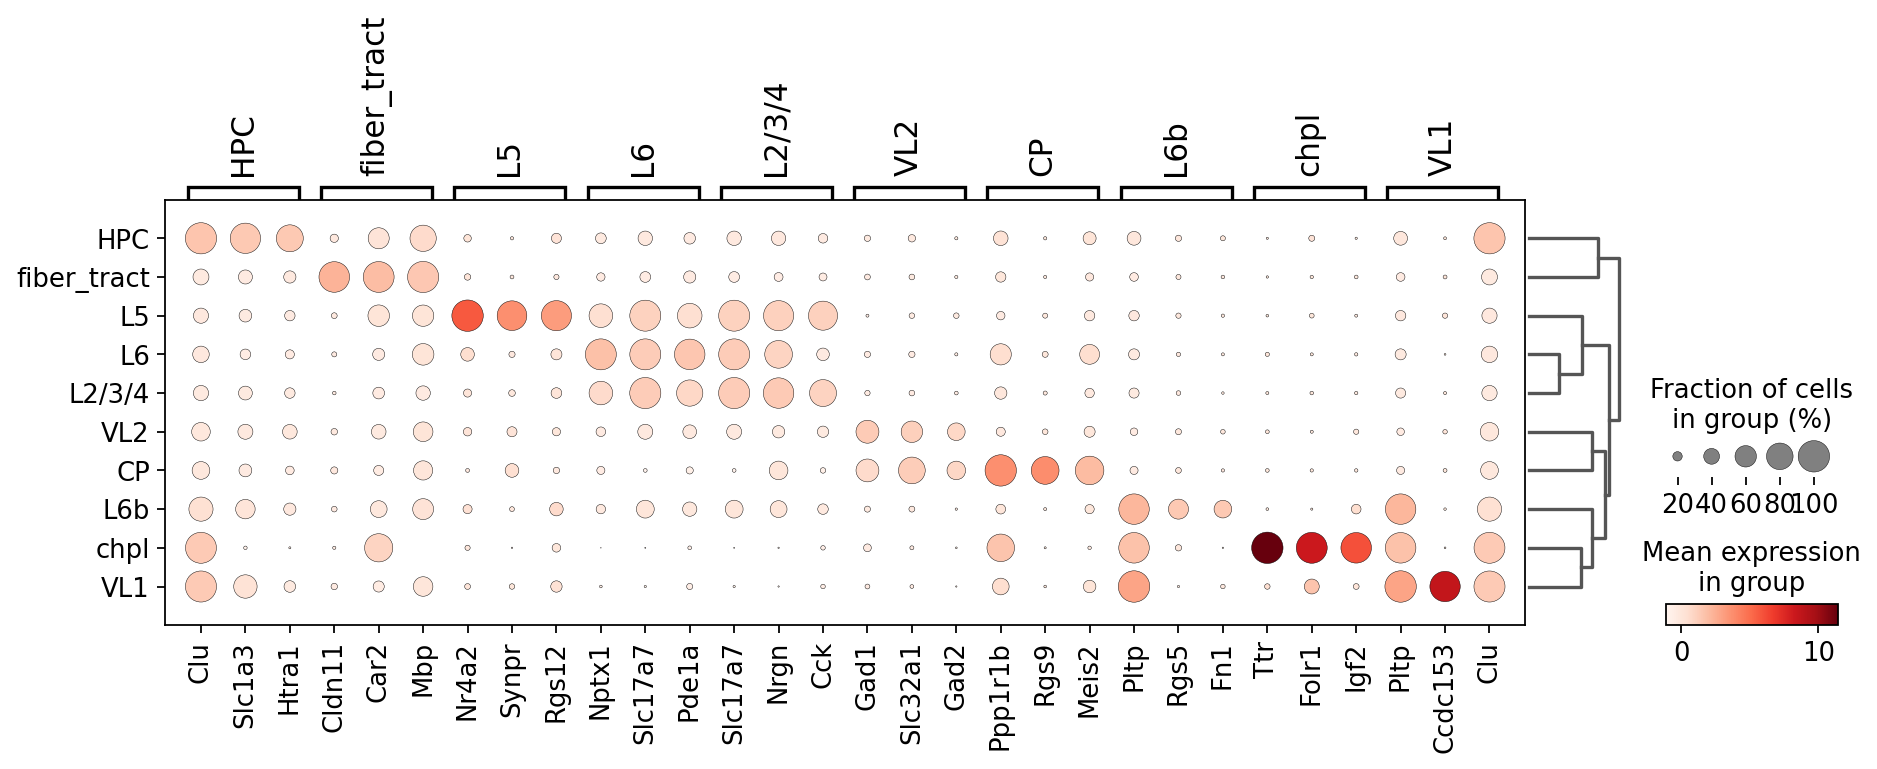

/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldc

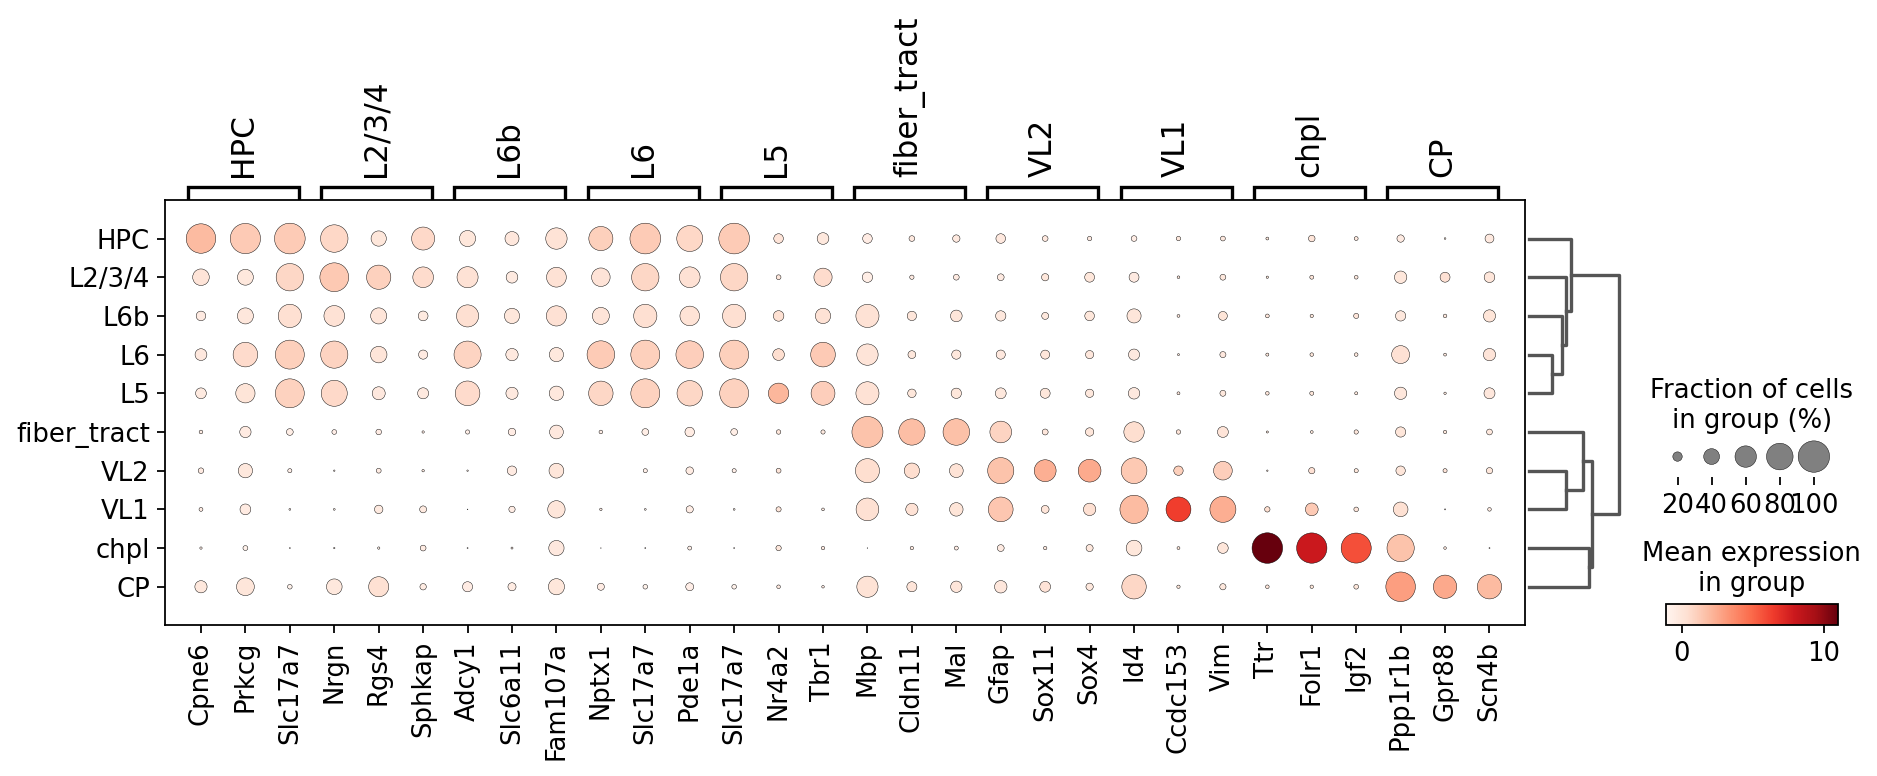

/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldc

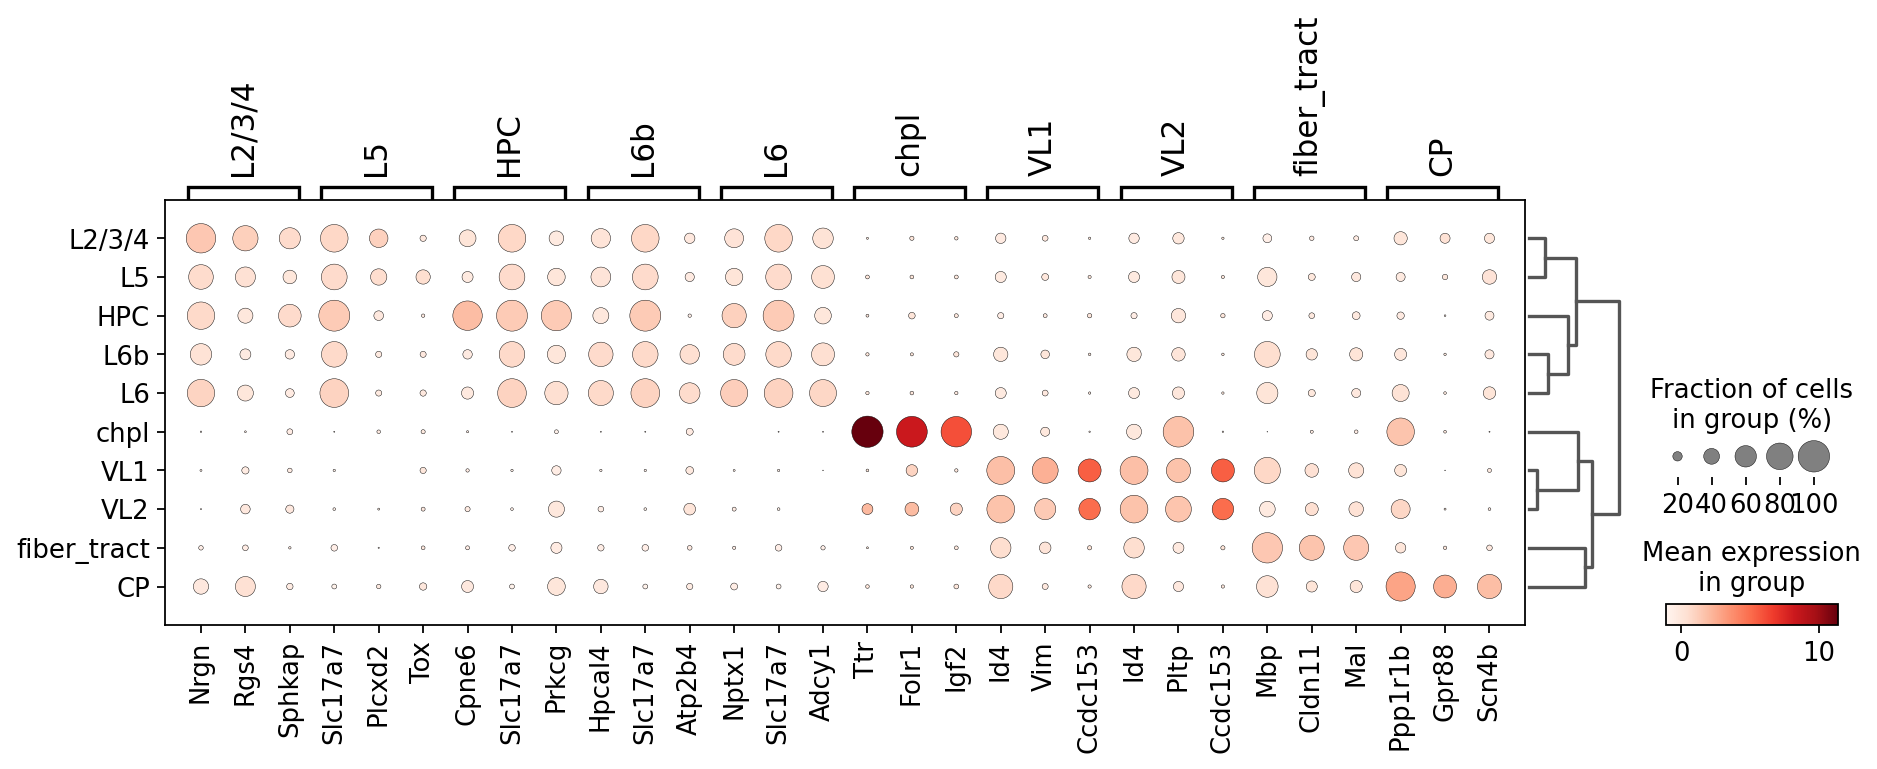

/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldc

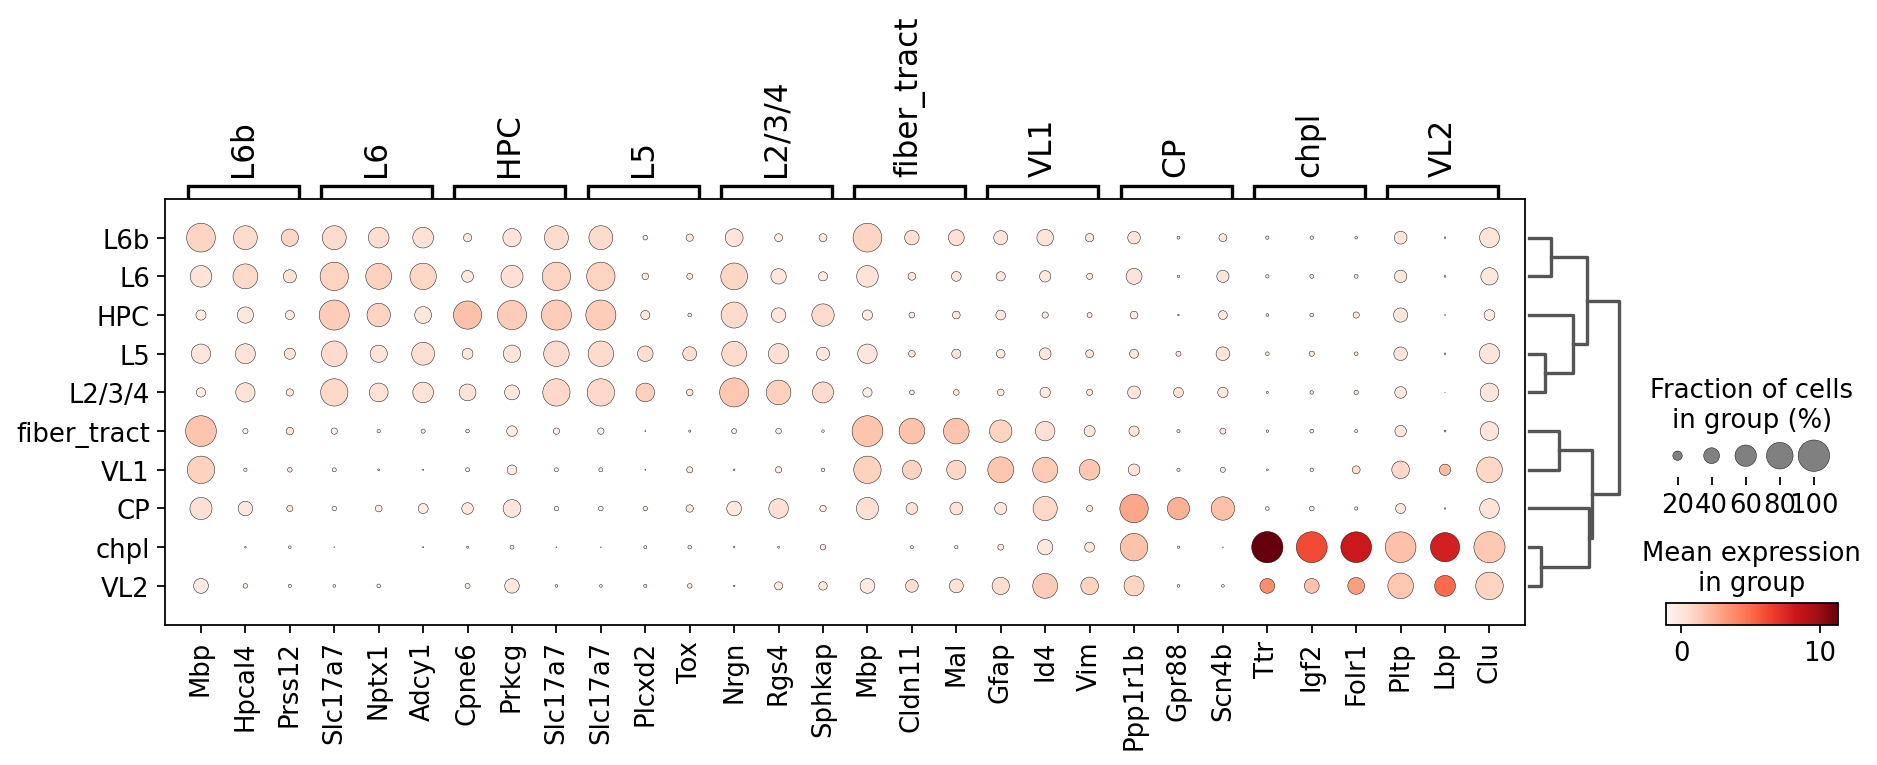

In [121]:
for n_nbrs in n_nbrs_list:

    sc.tl.rank_genes_groups(subdata, groupby=f'region_{n_nbrs}')
    sc.pl.rank_genes_groups_dotplot(subdata, n_genes=3)

### Vascular

In [138]:
n_nbrs = 1
sc.tl.rank_genes_groups(subdata, groupby=f'region_{n_nbrs}')
vasc_markers = sc.get.rank_genes_groups_df(subdata, group='L6b')['names']

/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldc

In [139]:
vasc_markers

0         Pltp
1         Rgs5
2          Fn1
3          Vtn
4         Lef1
         ...  
1017    Opalin
1018    Cldn11
1019       Lbp
1020       Trf
1021    Hapln2
Name: names, Length: 1022, dtype: object

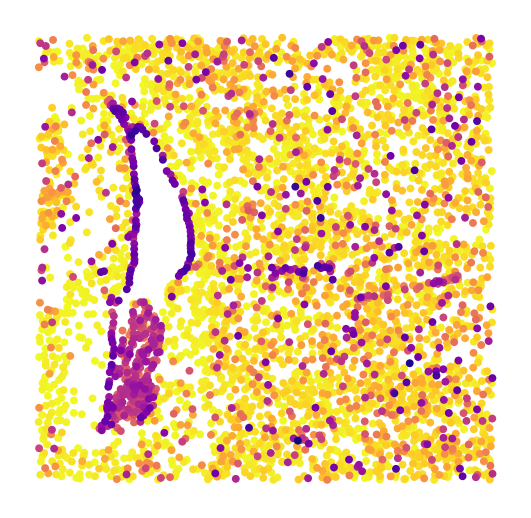

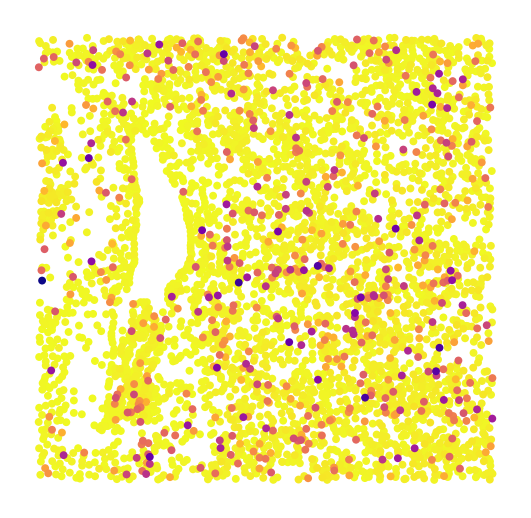

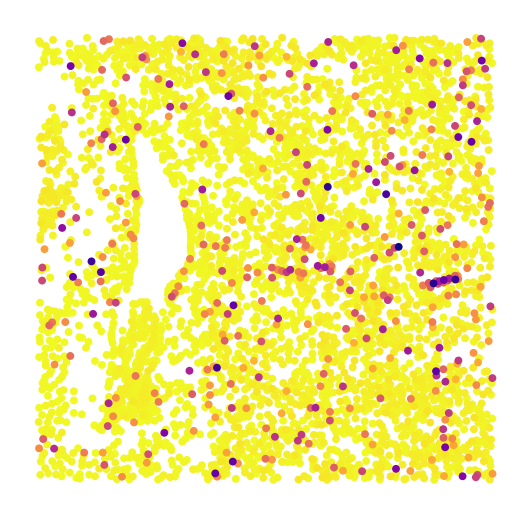

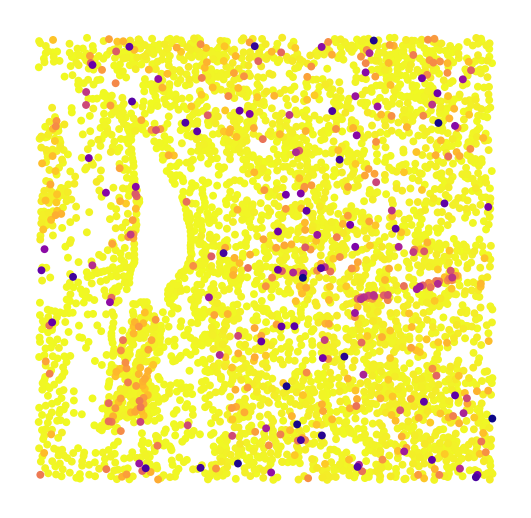

In [160]:
for gene in vasc_markers[:4]:

    sc.pl.embedding(subdata, basis='spatial', color=gene, cmap='plasma_r', colorbar_loc=None, return_fig=True, title='', s=50)
    plt.axis('off')
    figname = f'zoom_colored_by_{gene}.png'
    savepath = os.path.join(basepath, figname)
    plt.savefig(savepath, bbox_inches='tight', transparent=True, dpi=dpi)

### L6b

In [164]:
n_nbrs = 30
sc.tl.rank_genes_groups(subdata, groupby=f'region_{n_nbrs}')
l6b_markers = sc.get.rank_genes_groups_df(subdata, group='L6b')['names']

/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/stanley/WangLab/envs/neighbors/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldc

In [165]:
l6b_markers

0          Mbp
1       Hpcal4
2       Prss12
3       Atp2b4
4        Nxph3
         ...  
1017    Igfbp2
1018     Folr1
1019      Nefm
1020       Lbp
1021      Rgs4
Name: names, Length: 1022, dtype: object

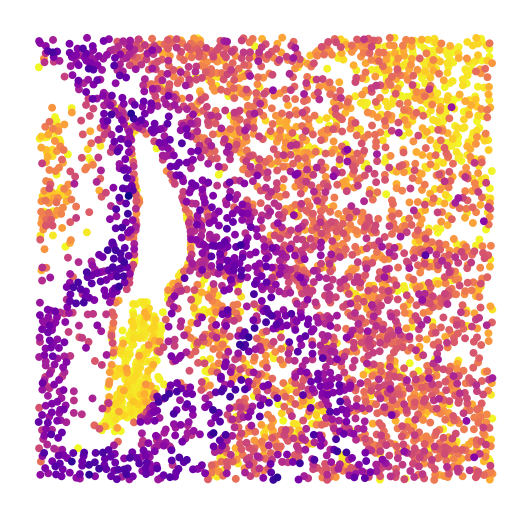

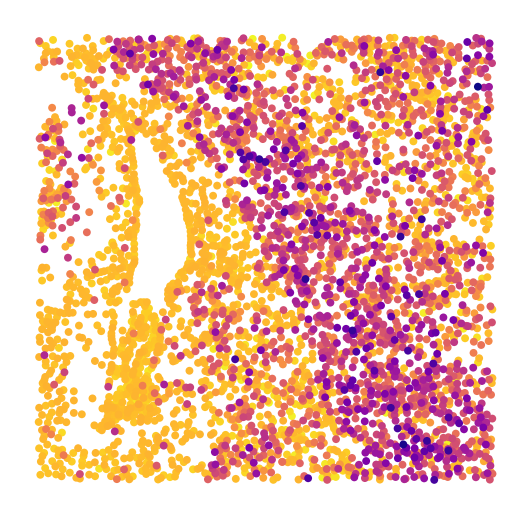

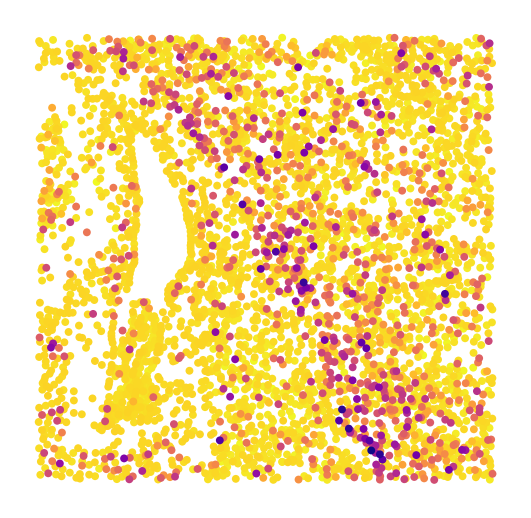

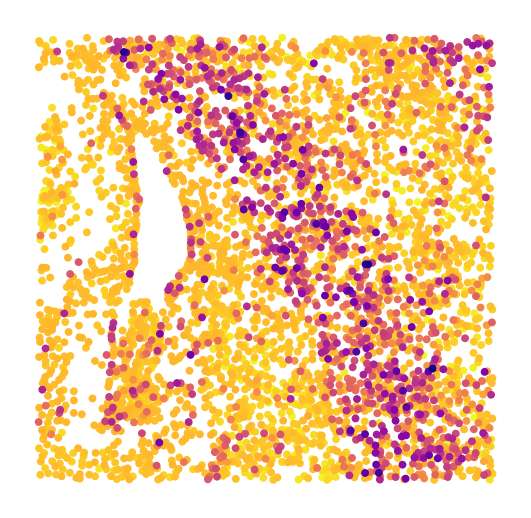

In [166]:
for gene in l6b_markers[:4]:

    sc.pl.embedding(subdata, basis='spatial', color=gene, cmap='plasma_r', colorbar_loc=None, return_fig=True, title='', s=50)
    plt.axis('off')
    figname = f'zoom_colored_by_{gene}.png'
    savepath = os.path.join(basepath, figname)
    plt.savefig(savepath, bbox_inches='tight', transparent=True, dpi=dpi)